## Εργαστηριακή Άσκηση 6
Σε αυτή την άσκηση δημιουργούμε ένα σύστημα που προτείνει ταινίες σε χρήστες σύμφωνα με τις ταινίες που έχουν
παρακολουθήσει και τις αξιολογήσεις που έχουν κάνει. Έχουμε στη διάθεσή μας τρία datasets τα οποία περιέχουν πληροφορίες για τις ταινίες, για τους χρήστες και για τις αξιολογήσεις αντίστοιχα.

Για την υλοποίηση της άσκησης χρησιμοποιούμε τον αλγόριθμο KMeans καθώς φαίνεται αποτελεσματικός και ιδιαίτερα ταιριαστός για το συγκεκριμένο πρόβλημα. Αυτό που κάνουμε συνοπτικά(περισσότερες λεπτομέρειες θα υπάρχουν στο αντίστοιχο section της άσκησης) είναι να εκτελέσουμε τον αλγόριθμο στα δεδομένα όπου κάθε δείγμα αντιστοιχεί στην αξιολόγηση ενός χρήστη σε μία ταινία και οι διαστάσεις που έχουμε συνεπώς είναι το σύνολο των ταινιών(εδώ 3883). Εφόσον έχουμε 6040 χρήστες ο αλγόριθμος θα τρέξει σε 6040x3883 = 23453320 δείγματα, αν και πραγματικά είναι αρκετά λιγότερα από αυτά αφού οι χρήστες δεν έχουν κάνει αξιολογήσεις για όλες τις ταινίες. Έτσι ο αλγόριθμος ομαδοποιεί τους χρήστες σε κάποια clusters και έτσι για κάποιο χρήστη μπορούμε να του προτείνουμε ταινίες που δεν έχει δει με βάση τις αξιολογήσεις που έχουν κάνει οι άλλοι χρήστες στο cluster του.

Επίσης να πούμε ότι εφόσον έχουμε το dataset για τους χρήστες μπορούμε να χρησιμοποιήσουμε και άλλη πληροφορία εκτός από την αξιολόγηση ταινιών για το clustering που πραγματοποιεί ο αλγόριθμος. Αυτό το κάνουμε στην άσκηση και προσθέτουμε μία επιπλέον στήλη(διαστάση) στα δεδομένα όπου περιέχει για κάθε χρήστη την ηλικία του. Βέβαια αυτή η διάσταση είναι μόνο μία από τις πλέον 3884 και κατά συνέπεια είναι ουσιαστικά αμελητέα. Δεν μπορούμε να βάλουμε και άλλη πληροφορία από τους χρήστες σαν επιπλέον στήλη στα δεδομένα που θα δώσουμε στον KMeans γιατί τα υπόλοιπα είναι κατηγορικά δεδομένα και η ευκλείδεια απόσταση δεν σημαίνει κάτι.

### Εισαγωγή βιβλιοθηκών
Εισάγουμε τις απαραίτητες βιβλιοθήκες για την υλοποίηση της άσκησης

In [1]:
#βιβλιοθήκη ανάλυσης δεδομένων, τη χρησιμοποιούμε για να εισάγουμε τα δεδομένα σε dataframes
import pandas as pd
#βιβλιοθήκη για οπτικοποίηση δεδομένων, τη χρησιμοποιούμε για τα γραφήματα
import matplotlib.pyplot as plt
#βιβλιοθήκη για επιστημονικούς υπολογισμούς, τη χρησιμοποιούμε για πίνακες και άλλες συναρτήσεις
import numpy as np
#χρησιμοποιείται για αραιές δομές δεδομένων με αριθμητικά δεδομένα
from scipy.sparse import csr_matrix
from functools import reduce
#toolkit που περιέχει βοηθητικές συναρτήσεις για την εμφάνιση εικόνων στη matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
#βιβλιοθήκη που περιέχει συναρτήσεις και μετρικές για την αξιολόγηση προβλέψεων μοντέλων
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import mean_squared_error
#ο αλγόριθμος KMeans
from sklearn.cluster import KMeans


### Εισαγωγή δεδομένων
Στη συνέχεια κάνουμε import τα τρία datasets από τα csv αρχεία

In [2]:
#κάνουμε import το dataset των ταινιών
movies = pd.read_csv('movies.csv', sep="\t", encoding='latin1')
#με τη μέθοδο head εμφανίζουμε τις 5 πρώτες γραμμές του dataframe
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
#κάνουμε import το dataset των αξιολογήσεων
ratings = pd.read_csv('ratings.csv', sep=";")
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
#κάνουμε import το dataset των χρηστών
users = pd.read_csv('users.csv', sep="\t")
users.head()

,user_id,gender,age,occupation,zipcode,age_desc,occ_desc
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,02460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer


Δημιουργούμε ένα dataframe όπου κάθε γραμμή είναι ένας χρήστης(index το user_id), κάθε στήλη είναι μια ταινία και οι τιμές είναι οι αξιολογήσεις των χρηστών στην αντίστοιχη ταινία. Μία τιμή NaN αντιπροσωπεύει ότι ο χρήστης δεν έχει αξιολογήσει την συγκεκριμένη ταινία. 

In [5]:
#ενώνουμε τα dataframes των αξιολογήσεων και ταινιών(με μόνο 2 στήλες) με κοινή στήλη την movie_id
ratings_title = pd.merge(ratings, movies[['movie_id', 'title']], on='movie_id' )
#κάνουμε τη στήλη user_id index του πίνακα και έτσι κάθε γραμμή αντιπροσωπεύει ένα χρήστη
user_movie_ratings = pd.pivot_table(ratings_title, index='user_id', columns= 'title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
#εκτυπώνουμε τις πρώτες 6 γραμμές και 10 στήλες του dataframe
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (6040, 3706) 

Subset example:


title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957)
user_id,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Συναρτήσεις που θα χρησιμοποιήσουμε
Εδώ ορίζουμε 5 συναρτήσεις που χρησιμοποιούμε. 

Η sort_by_rating_density επιστρέφει dataframe με συγκεκριμένες γραμμές και στήλες ταξινομημένες σε φθίνουσα σειρά ως προς ως προς την πληθηκότητα αξιολόγησης των ταινιών και την πληθηκότητα αξιολόγησης των χρηστών. Αυτή τη συνάρτηση τη χρησιμοποιούμε για να οπτικοποιήσουμε καλύτερα τις αξιολογήσεις σε ταινίες αφού οι πρώτες 5 γραμμές του πίνακα που εκτυπώνουμε έχουν NaN τιμές.

Η draw_movies_heatmap είναι η συνάρτηση που δημιουργεί το heatmap που έχουμε για την οπτικοποίηση του πίνακα με τις αξιολογήσεις για μία πιο γραφική μορφή.

Η clustering_errors υπολογίζει τα silhouette_score όταν εκτελείται ο αλγόριθμος με ένα συγκεκριμένο k και μας βοηθάει στο να επιλέξουμε το κατάλληλο αριθμό clusters για τον αλγόριθμο.

Η get_most_rated_movies χρησιμοποιείται από την sort_by_rating_density για να πάρει τις ταινίες που έχουν τις περισσότερες αξιολογήσεις. Δηλαδή αυτή τη λειτουργία δεν την εκτελεί η ίδια η συνάρτηση sort_by_rating_density.

Αντίστοιχα η get_users_who_rate_the_most χρησιμοποιείται από την sort_by_rating_density για να πάρει τους χρήστες που έχουν κάνει τις περισσότερες αξιολογήσεις.

In [7]:
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    #παίρνουμε τον πίνακα με ταξινομημένες στήλες ως προς την πληθηκότητα αξιολόγησης των ταινιών(με n_movies στήλες)
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    #παίρνουμε τον πίνακα με ταξινομημένες γραμμές ως προς την πληθηκότητα αξιολόγησης των χρηστών(με n_users γραμμές)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies


def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
    #φτιάχνουμε ένα figure με μέγεθος 15,4
    fig = plt.figure(figsize=(15,4))
    #παίρνουμε τους τρέχοντες άξονες ή δημιουργούμε καινούριους αν δεν υπάρχνουν
    ax = plt.gca()
    
    #σχεδιάζουμε το heatmap με range δεδομένων [0 5] 
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')

    if axis_labels:
        #κατασκευάζουμε τα σημεία(ticks) των αξόνων x, y με τη συνάρτηση arange που επιστρέφει πίνακα με ομοιόμορφες
        #τιμές στο διάστημα που δίνουμε και σαν διαστήματα δίνουμε τις διαστάσεις του πίνακα
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        #αντιστρέφουμε τον άξονα των y
        ax.invert_yaxis()
        #μεταφέρουμε τις τιμές του άξονα των x στην κορυφή για καλύτερη οπτικοποίηση
        ax.xaxis.tick_top()
        #θέτουμε στον πίνακα labels τις πρώτες 40 στήλες (ταινίες) ως string 
        labels = most_rated_movies_users_selection.columns.str[:40]
        #θέτουμε τα labels για τον άξονα των x(labels) και τον άξονα των y(τα user_id)
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        #προσθέτουμε στο plot το property να έχουν περιστραφεί τα labels για τον άξονα των x κατά 90 μοίρες
        #για να φαίνονται καλύτερα και να μην πιάνουν πολύ χώρο
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    #κρύβουμε τις γραμμές του grid για να φαίνεται καλύτερα
    ax.grid(False)
    ax.set_ylabel('User id')

    # δημιουργούμε το διαχωριστή του color bar που φαίνεται στα δεξιά και χωρίζει το color bar από το grid
    #με τη μέθοδο make_axes_locatable επιστρέφεται ένα στιγμιότυπο της κλάσης AxesDivider που παρέχει την append_axes
    #μέθοδο
    divider = make_axes_locatable(ax)
    # καλούμε την append_axes μέθοδο που δημιουργεί τον ξεχωριστό άξονα στα δεξιά των αρχικών αξόνων
    cax = divider.append_axes("right", size="5%", pad=0.05)

    #δημιουργούμε το colorbar με τα 5 επίπεδα και τα αντίστοιχα ονόματα
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

    plt.show()
    
    
def clustering_errors(k, data):
    #εκτελούμε KMeans με k clusters και παίρνουμε τις προβλέψεις
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #υπολογίζουμε το μέσο silhouette_score για τις προβλέψεις. Για κάθε δείγμα το score είναι (b - a) / max(a, b)
    #όπου a είναι η μέση εσωτερική απόσταση του cluster του δείγματος και b η μέση απόσταση μεταξύ του δείγματος και
    #του κοντινότερου cluster στο οποίο δεν ανήκει το δείγμα
    silhouette_avg = silhouette_score(data, predictions, metric='euclidean')
    return silhouette_avg


def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    #μετράμε για κάθε στήλη τα κελιά που δεν είναι NaN και το προσθέτουμε στην τελευταία γραμμή
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    #ταξινομούμε τις στήλες ως προς τις τιμές της τελευταίας γραμμής του πίνακα που έχει τα count
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    #αφαιρούμε τη τελευταία γραμμή που έχει τα counts αφού δε τη χρειαζόμαστε πλέον
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    #επιστρέφουμε μόνο τις πρώτες max_number_of_movies στήλες
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies


def get_users_who_rate_the_most(most_rated_movies, max_number_of_users):
    #προσθέτουμε τη στήλη counts που έχει για κάθε γραμμή(χρήστη) πόσες στήλες(ταινίες) είχαν τιμή όχι NaN
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    #ταξινομούμε τις γραμμές ως προς τη στήλη counts με φθίνουσα σειρά
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    #κρατάμε τις πρώτες max_number_of_users γραμμές
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_users, :]
    #διαγράφουμε τη στήλη counts αφού δε τη χρειαζόμαστε πια
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    
    return most_rated_movies_users_selection

### Οπτικοποίηση πινάκων
Το dataframe με τις αξιολογήσεις που είδαμε έχει NaN σε όλες τις αξιολογήσεις(στις γραμμές και στήλες που φαίνονται) το οποίο είναι φυσιολογικό αφού υπάρχουν πάρα πολλές ταινίες στα datasets. Για να δούμε καλύτερα τα δεδομένα θα δημιουργήσουμε ένα καινούριο dataframe στο οποίο θα ταξινομίσουμε τις ταινίες και τους χρήστες με τη συνάρτηση sort_by_rating_density που είδαμε πριν ουτοσώστε με τη συνάρτηση head να μπορούμε να δούμε αξιολογήσεις για κάποιες ταινίες. Επίσης για αυτό το dataframe θα εμφανίσουμε το heatmap.

In [8]:
n_movies = 30
n_users = 18
#καλούμε τη συνάρτηση sort_by_rating_density και αποθηκεύουμε τα αποτελέσματα στο most_rated_movies_users_selection
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

dataset dimensions:  (18, 30)


title,American Beauty (1999),Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode VI - Return of the Jedi (1983),Jurassic Park (1993),Saving Private Ryan (1998),Terminator 2: Judgment Day (1991),"Matrix, The (1999)",Back to the Future (1985),"Silence of the Lambs, The (1991)",...,E.T. the Extra-Terrestrial (1982),Star Wars: Episode I - The Phantom Menace (1999),Being John Malkovich (1999),"Shawshank Redemption, The (1994)","Godfather, The (1972)",Forrest Gump (1994),Ghostbusters (1984),Pulp Fiction (1994),"Terminator, The (1984)",Toy Story (1995)
4577,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,...,4.0,3.0,5.0,5.0,4.0,5.0,4.0,5.0,5.0,4.0
5053,3.0,5.0,4.0,4.0,5.0,4.0,4.0,3.0,5.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,5.0
4883,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,...,5.0,2.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0
1634,5.0,5.0,5.0,5.0,4.0,5.0,4.0,5.0,4.0,5.0,...,5.0,5.0,5.0,5.0,5.0,3.0,4.0,5.0,4.0,5.0
1631,4.0,5.0,5.0,5.0,3.0,4.0,2.0,2.0,3.0,3.0,...,4.0,5.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0


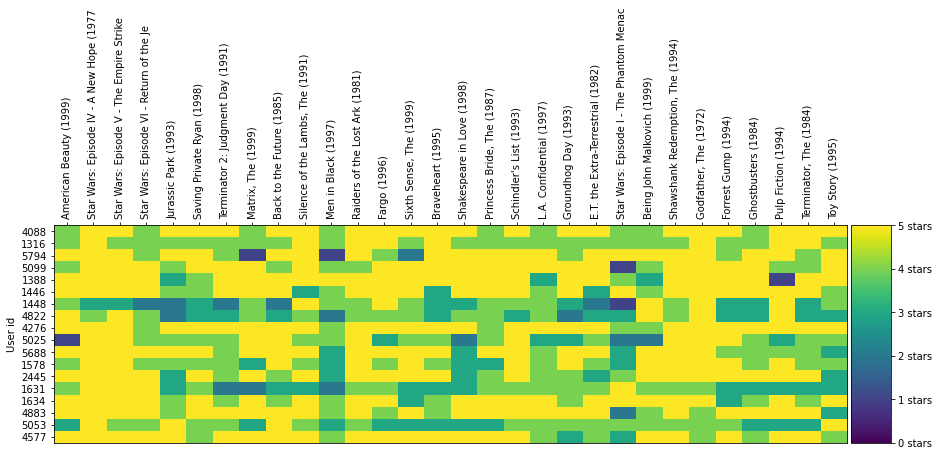

In [9]:
draw_movies_heatmap(most_rated_movies_users_selection)

### Κατασκευή δεδομένων για τον αλγόριθμο
Όπως αναφέραμε στην αρχή στον αλγόριθμο θα δώσουμε και την πληροφορία για την ηλικία του κάθε χρήστη. Επομένως στον πίνακα user_movie_ratings που έχουμε θα πρέπει να προσθέσουμε αυτή τη μία στήλη και στη συνέχεια να προσαρμόσουμε τα δεδομένα ώστε να να μπορεί να τα δεχθεί ο KMeans. Βεβαίως να ξαναπούμε ότι αυτή η στήλη δεν θα κάνει ουσιαστική διαφορά στην ομαδοποίηση του αλγορίθμου και να μην την προσθέταμε η συμπεριφορά του θα ήταν η ίδια.

In [10]:
#φτιάχνουμε το dataframe final που προσθέτουμε στο user_movie_ratings το age του χρήστη
final = pd.merge(users[['user_id', 'age']], user_movie_ratings, on='user_id')
print(final.shape)
final.head()

(6040, 3708)


,user_id,age,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Παρακάτω αλλάζουμε τον τύπο δεδομένων του πεδίου age για να είναι ίδιος με αυτό των αξιολογήσεων ουτοσώστε να μπορέσουμε να δημιουργήσουμε το αραιό μητρώο για τον KMeans.

In [11]:
#θέτουμε το user_id σαν index
final = pd.pivot_table(final, index='user_id')
#μετατρέπουμε το πεδίο age σε float64 για να το δεχθεί το sparse matrix
final['age'] = np.float64(final['age'])
print(final.dtypes)
final.head()

$1,000,000 Duck (1971)                        float64
'Night Mother (1986)                          float64
'Til There Was You (1997)                     float64
'burbs, The (1989)                            float64
...And Justice for All (1979)                 float64
                                               ...   
Zero Effect (1998)                            float64
Zero Kelvin (Kjærlighetens kjøtere) (1995)    float64
Zeus and Roxanne (1997)                       float64
age                                           float64
eXistenZ (1999)                               float64
Length: 3707, dtype: object


,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),age,eXistenZ (1999)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN


Εδώ δημιουργούμε ένα sparse_matrix γιατί ο KMeans δεν δέχεται δεδομένα με NaN τιμές, αλλά μόνο αριθμητικά δεδομένα.

In [12]:
#μετατρέπουμε το final dataframe σε sparse matrix για να απαλείψουμε τις NaN τιμές για τον KMeans 
from scipy.sparse import spmatrix
#μετατρέπουμε το dataframe σε sparse dataframe και για τη μετατροπή σε sparse matrix χρησιμοποιούμε τη μέθοδο to_coo
sparse_ratings = csr_matrix(pd.SparseDataFrame(final).to_coo())

c:\users\nickb\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  after removing the cwd from sys.path.
c:\users\nickb\anaconda3\envs\myenv\lib\site-packages\pandas\core\frame.py:3451: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return klass(values, index=self.index, name=items, fastpath=True)


### Επιλογή K
Ο KMeans δέχεται σαν όρισμα τον αριθμό των clusters στα οποία θα ομαδοποιήσει τα δεδομένα. Επομένως πρέπει να αποφασίσουμε τί k θα δώσουμε ως είσοδο. Για να το καθορίσουμε αυτό έχουμε δημιουργήσει τη συνάρτηση clustering_errors όπου για μία δεδομένη τιμή k εκτελεί τον KMeans στα δεδομένα και υπολογίζει ένα silhouette_score (περισσότερες λεπρομέρειες στην υλοποίηση της συνάρτησης). Επομένως καλούμε τη συνάρτηση για όλες τις τιμές του k που θέλουμε και μετά κάνουμε plot αυτές τις τιμές ανά k για καλύτερη οπτικοποίηση.

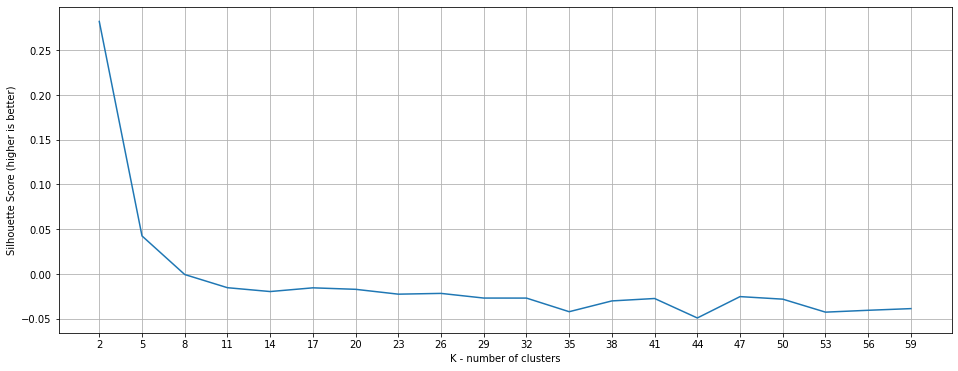

In [13]:
#X είναι τα δεδομένα στα οποία εκτελείται ο KMeans
X = sparse_ratings
#Θα δοκιμάσουμε πιθανές τιμές για τον αριθμό των clusters από 2 μέχρι 60 με βήμα 3
possible_k_values = range(2, 60, 3)
#καλούμε τη συνάρτηση clustering_errors αρκετές φορές για να πάρουμε όλα τα silhouette_score για τα αντίστοιχα k
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_values, errors_per_k)

#Ορίζουμε τις τιμές(ticks) των αξόνων x,y για τον άξονα των x θα είναι οι τιμές των k και για τον άξονα των y θα είναι
#το διάστημα μέγιστου - ελάχιστου silhouette_score με βήμα 0.05
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 3.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
#Ορίζουμε τις γραμμές του grid
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

### Εκτέλεση αλγορίθμου, αποτελέσματα και προτάσεις ταινιών
Όπως βλέπουμε παίρνουμε την καλύτερη απόδοση για k=2. Και στην περίπτωση που δεν προσθέσαμε τις δύο στήλες για ηλικία και occupation και οι στήλες ήταν μόνο οι ταινίες, το διάγραμμα ήταν το ίδιο και με 2 clusters εμφανιζόταν η καλύτερη απόδοση. Εμείς θα βάλουμε 3 clusters σαν είσοδο για να είναι πιο αραιές οι ομάδες και αυτό μπορεί να μας βοηθήσει αργότερα για την οπτικοποίηση. Σε αυτό το κομμάτι θα εκτελέσουμε τον αλγόριθμο, θα κάνουμε μερικές οπτικοποιήσεις για τα αποτελέσματα και θα κάνουμε προτάσεις ταινιών για κάποιο χρήστη.

In [14]:
#καλούμε τον kmeans και τώρα για κάθε χρήστη έχουμε ένα prediction για το ποιό cluster ανήκει 
predictions = KMeans(n_clusters=3, algorithm='full').fit_predict(sparse_ratings)

Εδώ προσθέτουμε στον πίνακα άλλη μία στήλη με την πρόβλεψη του αλγορίθμου για κάθε χρήστη, δηλαδή την ομάδα στην οποία ανήκει.

In [15]:
#προσθέτουμε τη στήλη prediction για να δούμε σε ποιό cluster ανήκει ο κάθε χρήστης
clustered = pd.concat([final.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
clustered.head()

,user_id,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),...,Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),age,eXistenZ (1999),group
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,NaN,2
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,1
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,NaN,2
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,1


Εδώ επιλέγουμε το δεύτερο cluster, το ταξινομούμε ως προς το πλήθος των αξιολογήσεων και εμφανίζουμε το heatmap για το συγκεκριμένο cluster.

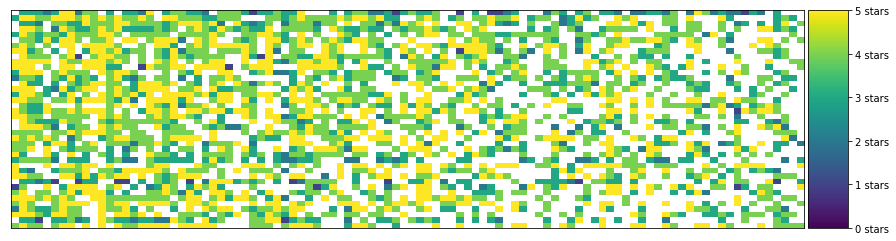

In [18]:
#παίρνουμε το cluster 2 και απαλείφουμε όλα τα πεδία εκτός από τα rating για απτικοποιήσουμε το cluster
cluster = clustered[clustered.group == 2].drop(['user_id', 'age', 'group'], axis=1)
#ταξινομούμε ως προς τη συχνότητα για να δούμε πιο χρήσιμη πληροφορία
cluster = sort_by_rating_density(cluster, 100, 40)
draw_movies_heatmap(cluster, axis_labels=False)

Εδώ εμφανίζουμε το cluster στη κανονική μορφή για να μπορούμε να επιλέξουμε κάποιο συγκεκριμένο χρήστη ή ταινία και αργότερα να κάνουμε τη πρόταση ταινιών.

In [19]:
#βλέπουμε το cluster σαν dataframe και όπου υπήρχε NaN βάλαμε το κενό
cluster.fillna('').head()

,American Beauty (1999),Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode VI - Return of the Jedi (1983),Shakespeare in Love (1998),Jurassic Park (1993),Saving Private Ryan (1998),Fargo (1996),Back to the Future (1985),"Silence of the Lambs, The (1991)",...,Mission: Impossible (1996),"Clockwork Orange, A (1971)",Moonstruck (1987),Diner (1982),American Graffiti (1973),Citizen Kane (1941),Planet of the Apes (1968),Indiana Jones and the Last Crusade (1989),"Patriot, The (2000)",Rain Man (1988)
2163,,3,3,3,2,3,5,5,2,4,...,2,2,1,3,2,,3,,,
664,3,5,5,4,4,5,5,5,4,5,...,3,,,,,,3,4,3,
527,,3,3,2,,4,4,3,3,5,...,,2,3,,3,,3,5,,4
958,,5,5,4,,2,5,4,3,3,...,,4,,,5,5,3,4,3,
1814,3,5,4,3,4,4,3,5,4,4,...,3,,,,,,,,4,


Η λογική που ακολουθούμε για τις προτάσεις ταινιών είναι η εξής: Επιλέγουμε ένα συγκεκριμένο cluster, από αυτό το cluster επιλέγουμε ένα συγκεκριμένο χρήστη, βρίσκουμε τις ταινίες που δεν έχει αξιολογήσει και αυτές τις ταινίες τις ταξινομούμε με φθίνουσα σειρά ως προς την μέση αξιολόγησή τους από τους υπόλοιπους χρήστες του cluster. Έτσι αφού οι χρήστες που ανήκουν στην ίδια ομάδα βαθμολόγησαν υψηλά κάποια ταινία, την προτείνουμε στον χρήστη εφόσον δεν την έχει δει.

In [20]:
movie_name = 'American Beauty (1999)'
#βλέπουμε τη μέση αξιολόγηση της ταινίας σε αυτό το cluster
cluster[movie_name].mean()

4.068965517241379

In [21]:
#βλέπουμε για τις 20 πρώτες στήλες το μέσο όρο των τιμών τους  (για όλες τις γραμμές, δηλαδή τους χρήστες)
cluster.mean().head(20)

American Beauty (1999)                                   4.068966
Star Wars: Episode IV - A New Hope (1977)                4.435897
Star Wars: Episode V - The Empire Strikes Back (1980)    4.055556
Star Wars: Episode VI - Return of the Jedi (1983)        3.566667
Shakespeare in Love (1998)                               4.038462
Jurassic Park (1993)                                     3.448276
Saving Private Ryan (1998)                               4.406250
Fargo (1996)                                             4.315789
Back to the Future (1985)                                3.500000
Silence of the Lambs, The (1991)                         4.312500
Schindler's List (1993)                                  4.440000
Godfather, The (1972)                                    4.766667
L.A. Confidential (1997)                                 3.945946
Raiders of the Lost Ark (1981)                           4.333333
Terminator 2: Judgment Day (1991)                        3.875000
Men in Bla

In [22]:
user_id = 958
#παίρνουμε τη γραμμή του πίνακα για το συγκεκριμένο χρήστη (με όλες τις στήλες)
user_2_ratings  = cluster.loc[user_id, :]
#παίρνουμε όλες τις στήλες που δεν έχουν αξιολόγηση (για το συγκεκριμένο χρήστη)
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]
#παίρνουμε για όλες αυτές τις στήλες(ταινίες) το μέσο όρο τους(μέση αξιολόγηση) στο cluster και τις αποθηκεύουμε
#στο dataframe avg_ratings 
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]
#τις ταξινομούμε με φθίνουσα σειρά και εμφανίζουμε τις top 20
avg_ratings.sort_values(ascending=False)[:20]

Toy Story 2 (1999)                  4.272727
African Queen, The (1951)           4.240000
Usual Suspects, The (1995)          4.166667
American Beauty (1999)              4.068966
Shakespeare in Love (1998)          4.038462
Princess Bride, The (1987)          3.960000
Erin Brockovich (2000)              3.909091
Matrix, The (1999)                  3.851852
Hunt for Red October, The (1990)    3.833333
Rain Man (1988)                     3.818182
Die Hard (1988)                     3.814815
Diner (1982)                        3.785714
Thelma & Louise (1991)              3.714286
Dances with Wolves (1990)           3.695652
Stand by Me (1986)                  3.666667
Talented Mr. Ripley, The (1999)     3.647059
Aliens (1986)                       3.607143
Moonstruck (1987)                   3.600000
Lethal Weapon (1987)                3.588235
Chicken Run (2000)                  3.562500
Name: 0, dtype: float64

### Οπτικοποίηση δεδομένων
Αυτό είναι το τελευταίο κομμάτι όπου κάνουμε οπτικοποίηση κάποιων δεδομένων για να δούμε σχέσεις ορισμένων ομάδων χρηστών με διάφορα είδη ταινιών. Έχουμε δύο διαφορετικά είδη οπτικοποίησης: Το ένα είναι διάγραμμα όπου φαίνονται οι μέσες αξιολογήσεις χρηστών συγκεκριμένου φύλλου(άντρες ή γυναίκες) για δύο είδη ταινιών(genres) και συνεπώς οπτικοποιείται σε διάγραμμα με δύο άξονες. Το δεύτερο είναι πίνακας όπου για κάθε είδος ταινίας έχει την μέση αξιολόγηση αυτού του είδους ταινίας(genre) ανά κάποιο συγκεκριμένο πεδίο από το dataset των χρηστών(π.χ. ανά ηλικία ή occupation).

In [23]:
#φτιάχνουμε ένα dataframe merged που περιέχει όλη τη πληροφορία που χρειαζόμαστε για τις οπτικοποιήσεις
merged = pd.merge(ratings[['user_id', 'movie_id', 'rating']], movies[['movie_id', 'genres']], on='movie_id')
merged = pd.merge(merged, users[['user_id', 'gender', 'age', 'occupation']], on='user_id')
print(merged.shape)
merged.head()

(1000209, 7)


,user_id,movie_id,rating,genres,gender,age,occupation
0,1,1193,5,Drama,F,1,10
1,1,661,3,Animation|Children's|Musical,F,1,10
2,1,914,3,Musical|Romance,F,1,10
3,1,3408,4,Drama,F,1,10
4,1,2355,5,Animation|Children's|Comedy,F,1,10


Παρακάτω είναι 2 συναρτήσεις για την κατασκευή του dataframe που θέλουμε για το πρώτο είδος οπτικοποίησης και για την σχεδίαση του διαγράμματος αντίστοιχα.

In [24]:
def get_genre_ratings(merged, genres, gender, column_names):
    #το dataframe που θα επιστρέψουμε
    genre_ratings = pd.DataFrame()
    #loop για κάθε genre
    for genre in genres:
        #βάζουμε φίλτρα για να πάρουμε τις γραμμές με το συγκεκριμένο genre και φύλο
        filter1 = merged['genres'].str.contains(genre)
        filter2 = merged['gender'].isin([gender])
        #παίρνουμε από αυτές τις γραμμές για κάθε χρήστη το μέσο όρο των αξιολογήσεών του για τις ταινίες με το συγκεκριμένο genre
        avg_genre_votes_per_user = merged[filter1 & filter2].loc[:, ['user_id', 'rating']].groupby(['user_id'])['rating'].mean().round(2)
        #βάζουμε τη πληροφορία για το συγκεκριμένο genre στο dataframe genre_ratings
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings

def draw_scatterplot(x_data, x_label, y_data, y_label):
    #δημιουργούμε ένα καινούριο figure με μέγεθος 10,10
    fig = plt.figure(figsize=(10,10))
    #προσθέτουμε άξονες με 1 γραμμή, 1 στήλη και index 1 (πάνω αριστερή γωνία)
    ax = fig.add_subplot(111)

    #τα όρια στον άξονα των x και y
    plt.xlim(0, 5.5)
    plt.ylim(0, 5.5)
    #τα labels για τους άξονες
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    #βάλε τα δεδομένα στους άξονες με μέγεθος του marker 30
    ax.scatter(x_data, y_data, s=30)

In [25]:
#βλέπουμε για κάθε χρήστη μου είναι γυναίκα τη μέση αξιολόγησή της για ταινίες romance και scifi
genre_ratings_1 = get_genre_ratings(merged, ['Romance', 'Sci-Fi'], 'F', ['avg_romance_rating', 'avg_scifi_rating'])
print(genre_ratings_1.shape)
genre_ratings_1.head()

(1708, 2)


,avg_romance_rating,avg_scifi_rating
1,3.67,4.33
6,4.00,3.50
10,4.37,4.18
11,3.09,1.75
16,3.27,3.20


Στο παρακάτω διάγραμμα κάθε σημείο είναι η μέση αξιολόγηση χρηστών για τα είδη ταινιών Romance και Scifi που είναι γυναίκες.

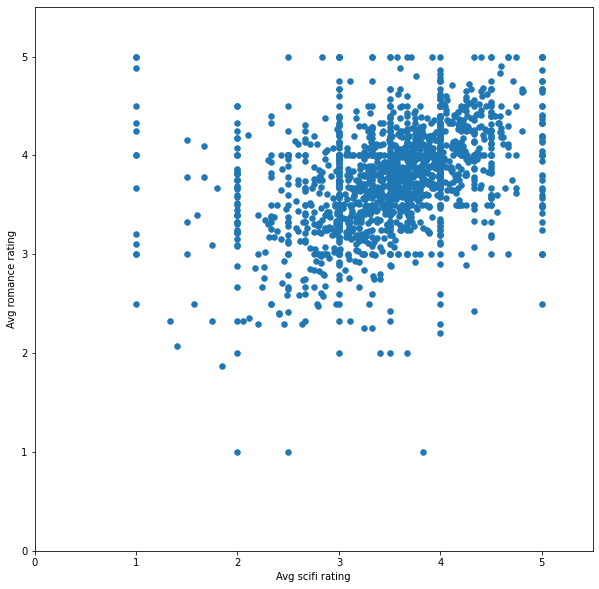

In [26]:
draw_scatterplot(genre_ratings_1['avg_scifi_rating'],'Avg scifi rating', genre_ratings_1['avg_romance_rating'], 'Avg romance rating')

In [27]:
#βλέπουμε για κάθε χρήστη μου είναι άντρας τη μέση αξιολόγησή του για ταινίες romance και scifi
genre_ratings_2 = get_genre_ratings(merged, ['Romance', 'Sci-Fi'], 'M', ['avg_romance_rating', 'avg_scifi_rating'])
#print(genre_ratings.shape)
genre_ratings_2.head()

,avg_romance_rating,avg_scifi_rating
2,3.71,3.59
3,3.80,3.83
4,4.00,3.56
5,3.10,3.07
7,4.00,4.30


Στο παρακάτω διάγραμμα κάθε σημείο είναι η μέση αξιολόγηση χρηστών για τα είδη ταινιών Romance και Scifi που είναι άντρες.

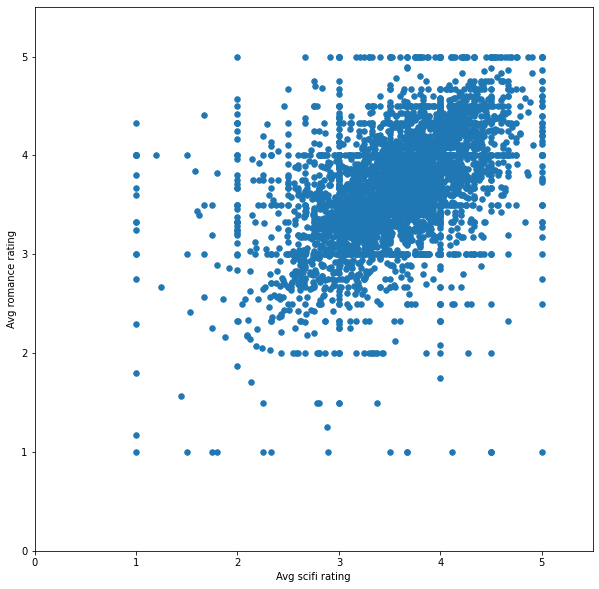

In [28]:
draw_scatterplot(genre_ratings_2['avg_scifi_rating'],'Avg scifi rating', genre_ratings_2['avg_romance_rating'], 'Avg romance rating')

Η παρακάτω συνάρτηση δημιουργεί τα dataframes στη μορφή που θέλουμε για το δεύτερο είδος οπτικοποίησης.

In [29]:
def get_array_vis(merged, variable):
    #παίρνουμε όλα τα ξεχωριστά genres στο dataframe merged, όμως είναι στη μορφή genre1|genre2|...
    genres = merged.genres.unique()
    g = [];
    g = np.array(g)
    #στον πίνακα g βάζουμε όλα τα ξεχωριστά genres που υπάρχουν στον πίνακα genres με χρήση της συνάρτησης split
    #που όμως τώρα θα επαναλαμβάνονται αφού για τα Comedy|Drama και Comedy|Romance θα π'αρουμε δύο φορές το Comedy
    for genre in genres:
        g = np.append(g, genre.split('|'))
    
    #απαλείφουμε τα επαναλαμβανόμενα στοιχεία
    all_genres = np.unique(g)
    #το dataframe που θα επιστρέψουμε
    genre_ratings = pd.DataFrame()
    for genre in all_genres:
        #παίρνουμε τις γραμμές με το συγκεκριμένο genre
        filter1 = merged['genres'].str.contains(genre)
        #παίρνουμε από αυτές τις γραμμές τις στήλες με το variable που δώσαμε και με το rating και βάζουμε ως index
        #τη στήλη variable και παίρνουμε τη μέση αξιολόγηση των ταινιών για τη συγκεκριμένη τιμή variable και το συγκεκριμένο genre
        avg_genre_votes_per_variable = merged[filter1].loc[:, [variable, 'rating']].groupby([variable])['rating'].mean().round(2)
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_variable], axis=1)

    genre_ratings.columns = all_genres;
    return genre_ratings
    

In [30]:
#βλέπουμε τη μέση αξιολόγηση για κάθε genre ανά occupation
res_1 = get_array_vis(merged, 'occupation')
res_1

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,3.42,3.43,3.68,3.44,3.49,3.65,3.85,3.74,3.43,4.06,3.13,3.66,3.59,3.57,3.40,3.49,3.85,3.62
1,3.39,3.42,3.69,3.46,3.52,3.66,3.98,3.75,3.46,4.08,3.10,3.70,3.69,3.61,3.40,3.53,3.88,3.63
2,3.46,3.44,3.62,3.38,3.50,3.68,4.03,3.73,3.42,4.11,3.24,3.61,3.72,3.59,3.50,3.56,3.86,3.61
3,3.55,3.56,3.82,3.61,3.60,3.74,3.85,3.79,3.47,4.08,3.30,3.86,3.75,3.70,3.56,3.65,3.93,3.63
4,3.45,3.42,3.66,3.35,3.49,3.72,3.96,3.75,3.36,4.04,3.17,3.64,3.58,3.56,3.42,3.51,3.86,3.52
5,3.49,3.48,3.77,3.51,3.47,3.70,3.89,3.74,3.43,4.03,3.28,3.64,3.62,3.56,3.45,3.54,3.76,3.61
6,3.56,3.55,3.68,3.49,3.59,3.80,4.01,3.87,3.49,4.01,3.26,3.65,3.78,3.71,3.47,3.65,4.01,3.74
7,3.57,3.51,3.70,3.44,3.52,3.74,3.92,3.77,3.47,4.03,3.22,3.67,3.68,3.62,3.50,3.63,3.91,3.64
8,3.45,3.40,3.53,3.23,3.48,3.58,3.90,3.63,3.41,3.88,3.01,3.56,3.49,3.57,3.41,3.45,3.78,3.71
9,3.60,3.69,3.80,3.67,3.58,3.64,3.80,3.79,3.61,3.68,3.27,3.85,3.66,3.76,3.49,3.66,3.88,3.50


In [31]:
#βλέπουμε τη μέση αξιολόγηση για κάθε genre ανά ηλικία
res_2 = get_array_vis(merged, 'age')
res_2

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1,3.51,3.45,3.48,3.24,3.50,3.71,3.73,3.79,3.32,4.15,3.25,3.57,3.63,3.62,3.48,3.55,3.90,3.58
18,3.45,3.41,3.62,3.29,3.46,3.67,3.87,3.72,3.35,4.00,3.17,3.56,3.53,3.53,3.43,3.49,3.85,3.47
25,3.45,3.44,3.70,3.43,3.49,3.68,3.95,3.73,3.45,4.06,3.20,3.62,3.61,3.55,3.44,3.54,3.84,3.61
35,3.54,3.52,3.74,3.52,3.56,3.73,3.95,3.78,3.48,4.06,3.28,3.72,3.70,3.65,3.50,3.62,3.90,3.68
45,3.53,3.53,3.73,3.53,3.59,3.75,3.97,3.78,3.53,4.11,3.26,3.74,3.75,3.69,3.48,3.64,3.96,3.67
50,3.61,3.63,3.78,3.56,3.65,3.81,3.91,3.88,3.58,4.18,3.16,3.80,3.89,3.76,3.56,3.71,3.97,3.74
56,3.61,3.65,3.76,3.62,3.65,3.83,3.96,3.93,3.53,4.13,3.25,3.89,3.89,3.82,3.50,3.72,4.07,3.79
